In [1]:
import time

import tqdm.notebook
# import time
%load_ext autoreload
%autoreload 2
# # %load_ext rich

In [19]:
import requests
import os
# %reload_ext autoreload
import allib
import importlib
import pandas as pd
import numpy as np

importlib.reload(allib)

<module 'allib' from '/Users/jecosine/Courses/COMP8800/Projects/CatBoostTutorial/allib/__init__.py'>

In [3]:
print(os.getcwd())
allib.datasets.load_uci("iris", reload=False, raw_path="../allib/datasets/uci_db.json")

/Users/jecosine/Courses/COMP8800/Projects/CatBoostTutorial/examples


In [4]:
uci_db = allib.datasets.get_uci_db()
print(len(uci_db.keys()))

614


In [5]:
# get attributes from datasets
print(f"total attributes: {len(uci_db['iris']['attributes'])}")
columns = []
for a in uci_db['iris']['attributes']:
    # handle name
    columns.append(a["name"].strip().lower().replace(" ", "_"))

total attributes: 5


In [6]:
d1 = pd.read_csv(os.path.join(allib.CACHE_DIR, "iris/iris.data"), skiprows=0, names=columns)
d2 = pd.read_csv(os.path.join(allib.CACHE_DIR, "iris/bezdekIris.data"), skiprows=0, names=columns)

In [8]:
d1["class"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [9]:
d2["class"].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [7]:
data = pd.concat((d1, d2)).reset_index(drop=True)
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,300.000000,300.000000,300.000000,300.000000
mean,5.843333,3.055667,3.758333,1.199000
std,0.826680,0.434007,1.761906,0.761423
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


<Axes: >

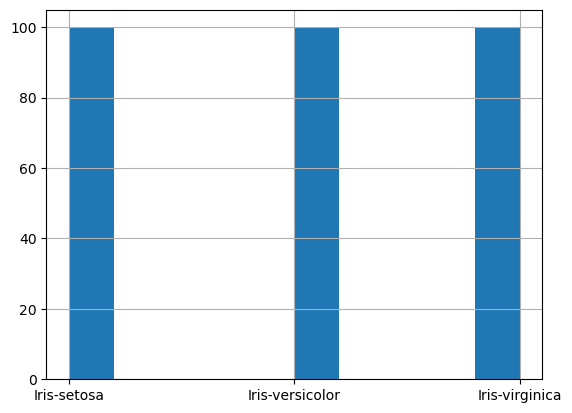

In [46]:
data["class"].hist()

In [47]:
# shuffle the dataset
from sklearn.utils import shuffle

data: pd.DataFrame = shuffle(data, random_state=42)
data.reset_index(drop=True)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.5,2.3,4.0,1.3,Iris-versicolor
1,6.5,3.0,5.5,1.8,Iris-virginica
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.9,3.1,1.5,0.1,Iris-setosa
4,6.0,2.7,5.1,1.6,Iris-versicolor
...,...,...,...,...,...
295,4.4,3.0,1.3,0.2,Iris-setosa
296,6.1,2.8,4.0,1.3,Iris-versicolor
297,4.9,2.5,4.5,1.7,Iris-virginica
298,6.9,3.2,5.7,2.3,Iris-virginica


In [8]:
# split training/testing
from sklearn.model_selection import train_test_split

data = data.rename(columns={"class": "label"})
label = data.label
data = data.drop(columns=["label"])

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, random_state=42)

In [40]:
import catboost
from catboost import CatBoostClassifier, sum_models, to_classifier
from catboost.utils import create_cd

In [58]:
# sample the initial datasets

X_init = X_train.sample(n=10)
Y_init = Y_train.loc[X_init.index]
X_train = X_train.drop(X_init.index)
Y_train = Y_train.drop(Y_init.index)

In [52]:
BATCH_SIZE = 20
accuracy_unc = []
instances = []
cur_model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
cur_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
models = [cur_model]
accuracy_unc.append(cur_model.score(X_test, Y_test))
instances.append(len(X_init))
while len(X_train) > 0:
    new_model = CatBoostClassifier(
        iterations=5,
        learning_rate=0.1,
        # loss_function='CrossEntropy'
    )

    if len(X_train) > BATCH_SIZE:
        # bottom BATCH_SIZE at score
        idx = cur_model.predict_proba(X_train).max(axis=1).argpartition(BATCH_SIZE)[:BATCH_SIZE]
        X_init = pd.concat((X_init, X_train.loc[X_train.index[idx]]))
        Y_init = pd.concat((Y_init, Y_train.loc[Y_train.index[idx]]))
        X_train = X_train.drop(X_train.index[idx])
        Y_train = Y_train.drop(Y_train.index[idx])
    else:
        X_init = pd.concat((X_init, X_train))
        Y_init = pd.concat((Y_init, Y_train))
        X_train = X_train.drop(X_train.index)
        Y_train = Y_train.drop(Y_train.index)
    new_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
    models.append(new_model)
    # todo: test merge strategy
    cur_model = to_classifier(sum_models(models, weights=[1.0 / len(models)] * len(models)))
    accuracy_unc.append(cur_model.score(X_test, Y_test))
    instances.append(len(X_init))

In [53]:
accuracy_unc

[0.8933333333333333,
 0.92,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96,
 0.96]

In [59]:
BATCH_SIZE = 20
accuracy_rand = []
instances = []
cur_model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
cur_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
models = [cur_model]
accuracy_rand.append(cur_model.score(X_test, Y_test))
instances.append(len(X_init))
while len(X_train) > 0:
    new_model = CatBoostClassifier(
        iterations=5,
        learning_rate=0.1,
        # loss_function='CrossEntropy'
    )
    l = min(BATCH_SIZE, len(X_train))
    X_new = X_train.sample(n=l)
    Y_new = Y_train.loc[X_new.index]
    X_train = X_train.drop(X_new.index)
    Y_train = Y_train.drop(Y_new.index)
    X_init = pd.concat((X_init, X_new))
    Y_init = pd.concat((Y_init, Y_new))
    new_model.fit(X_init, Y_init, eval_set=(X_test, Y_test), verbose=False)
    models.append(new_model)
    # todo: test merge strategy
    cur_model = to_classifier(sum_models(models, weights=[1.0 / len(models)] * len(models)))
    accuracy_rand.append(cur_model.score(X_test, Y_test))
    instances.append(len(X_init))

In [60]:
accuracy_rand

[0.84,
 0.8666666666666667,
 0.9466666666666667,
 0.9466666666666667,
 0.92,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9333333333333333,
 0.9466666666666667,
 0.9466666666666667]

In [28]:
idx = pred.max(axis=1).argpartition(-10)[-10:]

In [38]:
idx

array([ 42, 195, 165,  90, 160, 187,  79,  81, 133, 101])

In [62]:
class A:
    def __init__(self):
        self.x: str
        self.y: int

    def set_values(self, x, y):
        print(self.x)
        self.y = y

In [63]:
a = A()

In [64]:
a.set_values(1, 2)

AttributeError: 'A' object has no attribute 'x'

In [77]:
d = {"A": 1, "B":2} ^ {"A": 2, "B":3, "C": 4}
print(d)

TypeError: unsupported operand type(s) for ^: 'dict' and 'dict'

In [78]:
from sklearn.metrics import get_scorer

In [101]:
acc = get_scorer("accuracy")

In [106]:
acc.__name__ = '1'

In [108]:
from typing import List, Callable

def __name_metric(f: Callable, name: str):
    if f is None:
        return None
    f.__name__ = name
    return f
def get_metrics(names: List[str], ignore_error: bool = False):
    def suppress_error(name: str):
        try:
            func = get_scorer(name)
        except ValueError:
            return None
        else:
            return func

    getter = suppress_error if ignore_error else get_scorer
    return [
        func
        for name in names
        if (func := __name_metric(getter(name), name)) is not None
    ]

In [110]:
ms = get_metrics(["accuracy", "f1", "roc"],ignore_error=True)

                        Score of the 2th runs                        
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃       Metric ┃ Title                             ┃     Box Office ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Dec 20, 2019 │ Star Wars: The Rise of Skywalker  │   $952,110,690 │
│ May 25, 2018 │ Solo: A Star Wars Story           │   $393,151,347 │
│ Dec 15, 2017 │ Star Wars Ep. V111: The Last Jedi │ $1,332,539,889 │
│ Dec 16, 2016 │ Rogue One: A Star Wars Story      │ $1,332,439,889 │
└──────────────┴───────────────────────────────────┴────────────────┘

In [96]:
from tqdm.notebook import tqdm, trange
import time
it = MyIter()
for i in tqdm(range(10)):
    it2 = MyIter()
    for j in tqdm(it2, total=it.__len__()):
        # print(f"    {i}")
        time.sleep(0.5)
    time.sleep(0.5)
    print(i)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3.321928094887362 [00:00<?, ?it/s]

0


  0%|          | 0/3.321928094887362 [00:00<?, ?it/s]

1


  0%|          | 0/3.321928094887362 [00:00<?, ?it/s]

2


  0%|          | 0/3.321928094887362 [00:00<?, ?it/s]

3


  0%|          | 0/3.321928094887362 [00:00<?, ?it/s]

4


  0%|          | 0/3.321928094887362 [00:00<?, ?it/s]

5


  0%|          | 0/3.321928094887362 [00:00<?, ?it/s]

KeyboardInterrupt: 